In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm import tqdm

from uncoditioned_epsilon_theta_networks import TransEncoder

In [9]:
class Sine_Pytorch(torch.utils.data.Dataset):
    
    def __init__(self, no_samples, seq_len, features):
        
        self.data = []
        
        for i in range(no_samples):
            
            temp = []
            
            for k in range(features):
                
                freq = np.random.uniform(0, 0.1)
                
                phase = np.random.uniform(0, 0.1)
                
                temp_data = [np.sin(freq*j + phase) for j in range(seq_len)]
                
                temp.append(temp_data)
                
            temp = np.transpose(np.asarray(temp))
            
            temp = (temp + 1) * 0.5
            
            self.data.append(temp)
        
        self.data = np.asarray(self.data, dtype = np.float32)
        
    def __len__(self):
        
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        return self.data[idx, :, :]
    

def LoadData(seq_len, num_var):
    data = Sine_Pytorch(5000, seq_len, num_var)
    train_data, test_data = train_test_split(data, train_size = 0.8, random_state = 2021)
    return train_data, test_data

In [10]:
seq_len = 7
num_var = 1

train_data, test_data = LoadData(seq_len=seq_len, num_var=num_var)
train_data, test_data = np.asarray(train_data), np.asarray(test_data)

features = train_data.shape[2]

print(f"Train data shape: {train_data.shape}")

batch_size = 32
train_data, test_data = train_data.transpose(0,2,1), test_data.transpose(0,2,1)
train_loader = torch.utils.data.DataLoader(train_data, batch_size)
test_loader = torch.utils.data.DataLoader(test_data, len(test_data))

real_data = next(iter(train_loader))
print(f"batched data shape: {real_data.shape}")


for batch in real_data:
    print(batch)
    break

Train data shape: (4000, 7, 1)
batched data shape: torch.Size([32, 1, 7])
tensor([[0.5204, 0.5647, 0.6085, 0.6514, 0.6931, 0.7333, 0.7717]])


In [11]:
class Diffusion:
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.total_steps = total_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = self.linear_noise_schedule()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device)
                
    def linear_noise_schedule(self):
        scale = 1000 / self.total_steps
        beta_start = scale * self.beta_start
        beta_end = scale * self.beta_end
        betas = torch.linspace(beta_start, beta_end, self.total_steps)
        
        return betas
    
    def forward_process(self, x, t):
        # print(f"Device x:{x.device}")
        # print(f"Device alphas_cumprod:{self.alphas_cumprod.device}")
        sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None]
        sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
        
        noise = torch.randn_like(x)
        
        noisy_x = sqrt_alpha_cumprod * x + sqrt_one_minus_alpha_cumprod * noise
        
        return noisy_x, noise
    
    def reverse_process(self, epsilon_theta, x_t, t):
        betas = self.betas.to(self.device)
        alphas = self.alphas.to(self.device)
        sqrt_alpha_t = torch.sqrt(alphas[t])[:, None]
        betas_t = betas[t][:, None]
        sqrt_one_minus_alpha_cumpord_t = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
        epsilon_t = torch.sqrt(betas[t][:, None])
        
        random_noise = torch.randn_like(x_t)
        random_noise[t == 0] = 0.0
        
        model_mean = ((1 / sqrt_alpha_t) * (x_t - (betas_t * epsilon_theta / sqrt_one_minus_alpha_cumpord_t)))
        prev_x_t = model_mean + (epsilon_t * random_noise)
        
        return prev_x_t
        
    def sample_timestep(self, num_time_steps):
        t = torch.randint(low=1, high=self.total_steps, size=(num_time_steps,), device=self.device)
        return t

shape of batch: torch.Size([1, 7])


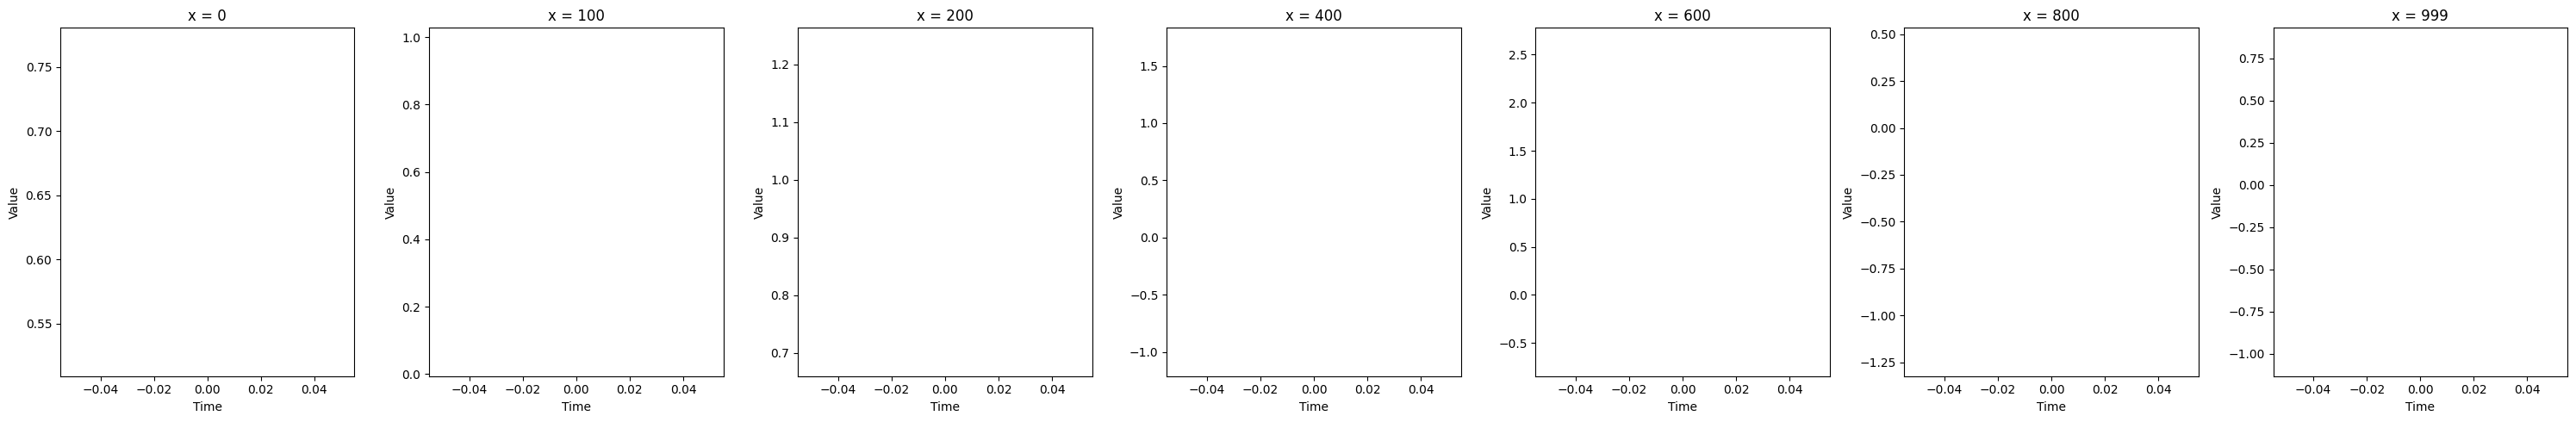

In [12]:
### Viz forward process
diff = Diffusion()

x_values = [0, 100, 200, 400, 600, 800, 999]
fig, axes = plt.subplots(1, len(x_values), figsize=(30, 5))

print(f"shape of batch: {batch.shape}")

for i, x in enumerate(x_values):
    noisy_ts, noise = diff.forward_process(batch, [x])
    axes[i].plot(noisy_ts)
    axes[i].set_title(f"x = {x}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()

In [13]:
epochs = 10
#device = "cuda:0"
device = "cpu"
learning_rate = 1e-4

epsilon_theta = TransEncoder()
diffuser = Diffusion()

optimizer = optim.Adam(epsilon_theta.parameters(), lr=learning_rate)
loss_fnc = nn.MSELoss()

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
train_epoch_losses = []

epsilon_theta = epsilon_theta.to(device)
epsilon_theta.train()

pbar = tqdm(iterable=range(epochs), position=0, leave=True)

for epoch in pbar:
    batch_losses = []
    
    for batch in train_loader:
        batch = batch.to(device)
        
        timesteps = diffuser.sample_timestep(batch.shape[0])

        #forward process
        batch_noise_t, noise_t = diffuser.forward_process(batch, timesteps)
        print(f"batch shape: {batch.shape}")
        print(f"noised batch shape: {batch_noise_t.shape}")
        #predict noise
        predicted_noise = epsilon_theta(batch_noise_t, timesteps)
        
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss.detach().cpu().numpy())
        
    batch_losses_mean = np.mean(np.array(batch_losses))
    train_epoch_losses.append(batch_losses_mean)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {batch_losses_mean:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

batch shape: torch.Size([32, 1, 7])
noised batch shape: torch.Size([32, 32, 7])
shape of x: torch.Size([32, 32, 7])
shape of x transposed: torch.Size([32, 7, 32])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (224x32 and 1x256)